# Week 9 Notebook: Select the Winning Model
The goal of this week's assignment is to evaluate all 9 models against a validation dataset, select the best-performing model and predict how well the selected model will perform on unseen data in production (i.e., your test data).

 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, root_mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import pickle


4.0


### Read data as dataframe

In [2]:
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)

model_folder = os.path.join(parent_dir,"models")
data_folder = os.path.join(parent_dir,"data")

raw_data_folder = os.path.join(data_folder,"raw")
interim_data_folder = os.path.join(data_folder,"interim")
processed_data_folder = os.path.join(data_folder, "processed")

In [3]:
# Paths for feature variables
X_train_scaled_path = os.path.join(processed_data_folder, 'X_train_scaled.parquet')
X_val_scaled_path = os.path.join(processed_data_folder, 'X_val_scaled.parquet')
X_test_scaled_path = os.path.join(processed_data_folder, 'X_test_scaled.parquet')

train_pca_path = os.path.join(processed_data_folder, 'X_train_pca.parquet')
val_pca_path = os.path.join(processed_data_folder, 'X_val_pca.parquet')
test_pca_path = os.path.join(processed_data_folder, 'X_test_pca.parquet')

X_train_poly_path = os.path.join(processed_data_folder, "X_train_poly.parquet")
X_val_poly_path = os.path.join(processed_data_folder, "X_val_poly.parquet")

# Paths for the target variables
y_train_path = os.path.join(processed_data_folder, 'y_train.parquet')
y_val_path = os.path.join(processed_data_folder, 'y_val.parquet')
y_test_path = os.path.join(processed_data_folder, 'y_test.parquet')

In [4]:
# Reading the parquet files as dataframes
X_train_scaled = pd.read_parquet(X_train_scaled_path)
X_val_scaled = pd.read_parquet(X_val_scaled_path)
X_test_scaled = pd.read_parquet(X_test_scaled_path)

y_train = pd.read_parquet(y_train_path)
y_val = pd.read_parquet(y_val_path)
y_test = pd.read_parquet(y_test_path)

X_train_pca = pd.read_parquet(train_pca_path)
X_val_pca = pd.read_parquet(val_pca_path)
X_test_pca = pd.read_parquet(test_pca_path)

### Load models

In [5]:
models = {}
model_names = []
for file_name in os.listdir(model_folder):
    if file_name.endswith('.pkl'):  # Check for pickle files
        model_name = file_name[:-4]  # Remove the .pkl extension
        model_names.append(model_name)
        file_path = os.path.join(model_folder, file_name)
        with open(file_path, 'rb') as file:
            models[model_name] = pickle.load(file)  # Load the model

print("Loaded models:", models)


/opt/tljh/user/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator Ridge from version 1.5.2 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/opt/tljh/user/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.5.2 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/opt/tljh/user/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.5.2 when using version 1.5.1. This might lead to 

Loaded models: {'l2_model': Ridge(alpha=100), 'rf3': RandomForestRegressor(max_depth=10, max_features=None, n_estimators=200,
                      random_state=42), 'ols_model': LinearRegression(), 'l1_model': Lasso(alpha=0.1), 'rt2': DecisionTreeRegressor(max_depth=15, min_samples_leaf=10, min_samples_split=10), 'rf2': RandomForestRegressor(max_depth=15, max_features=None, n_estimators=200,
                      random_state=42), 'ols_pca_model': LinearRegression(), 'rt1': DecisionTreeRegressor(), 'rf1': RandomForestRegressor(max_depth=15, max_features=None, random_state=42), 'rt3': DecisionTreeRegressor(ccp_alpha=0.001, max_depth=20, min_samples_leaf=10)}


### Define the function used to predict and evaluate the model

In [6]:
def evaluate_model(y_true, y_pred):
    rmse = root_mean_squared_error(y_true, y_pred)
    mse = rmse**2
    r2 = r2_score(y_true, y_pred)
    return mse, rmse, r2

In [7]:
def predict_on_val(model, model_name):
    if "pca" in model_name.lower():  # Use .lower() to ensure case-insensitive matching
        y_val_pred = model.predict(X_val_pca)

    elif "poly" in model_name.lower():
        y_val_pred = model.predict(X_val_poly)
    else:
        y_val_pred = model.predict(X_val_scaled)

    val_mse, val_rmse, val_r2 = evaluate_model(y_val, y_val_pred)

    return val_mse, val_rmse, val_r2


## Predict and Evaluate Models on the Validation Dataset

In [8]:
mse = []
rmse = []
r2 = []

for i in range(len(model_names)):
    model_name = model_names[i]
    print(f"Index: {i}, Model Name: {model_name}")
    model = models[model_name]
    
    val_mse, val_rmse, val_r2 = predict_on_val(model, model_name)
    mse.append(val_mse)
    rmse.append(val_rmse)
    r2.append(val_r2)


# Check if all metrics have been collected
print("MSE List Length:", len(mse))
print("RMSE List Length:", len(rmse))
print("R2 List Length:", len(r2))


Index: 0, Model Name: l2_model
Index: 1, Model Name: rf3
Index: 2, Model Name: ols_model
Index: 3, Model Name: l1_model
Index: 4, Model Name: rt2
Index: 5, Model Name: rf2
Index: 6, Model Name: ols_pca_model
Index: 7, Model Name: rt1
Index: 8, Model Name: rf1
Index: 9, Model Name: rt3
MSE List Length: 10
RMSE List Length: 10
R2 List Length: 10


## Select the winning model
### Bias and Variance Tradeoff

In [9]:
model_complexity = [9, 10, 8, 3, 5, 6, 7, 4, 2, 1]

In [10]:
metrics = {
    'model_name': model_names,
    'MSE': mse,
    'RMSE':rmse,
    'R2': r2,
    'model_complexity': model_complexity
}
df = pd.DataFrame(metrics)

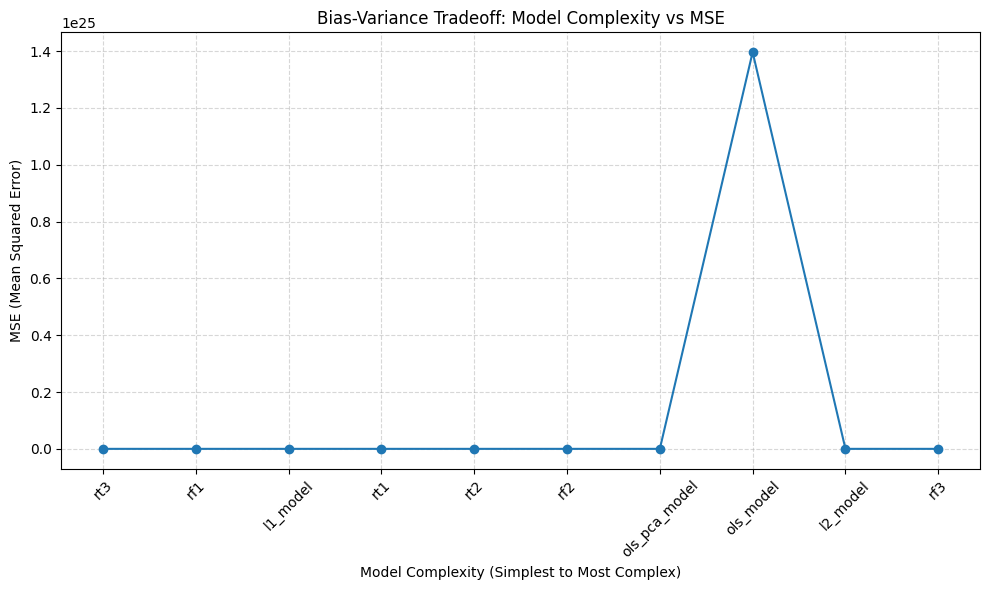

In [11]:
# Sort by model complexity for plotting
df = df.sort_values('model_complexity')

# Plot the MSE vs. Model Complexity
plt.figure(figsize=(10, 6))
plt.plot(df['model_complexity'], df['MSE'], marker='o', linestyle='-')
plt.xticks(df['model_complexity'], df['model_name'], rotation=45)
plt.xlabel('Model Complexity (Simplest to Most Complex)')
plt.ylabel('MSE (Mean Squared Error)')
plt.title('Bias-Variance Tradeoff: Model Complexity vs MSE')
plt.grid(visible=True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

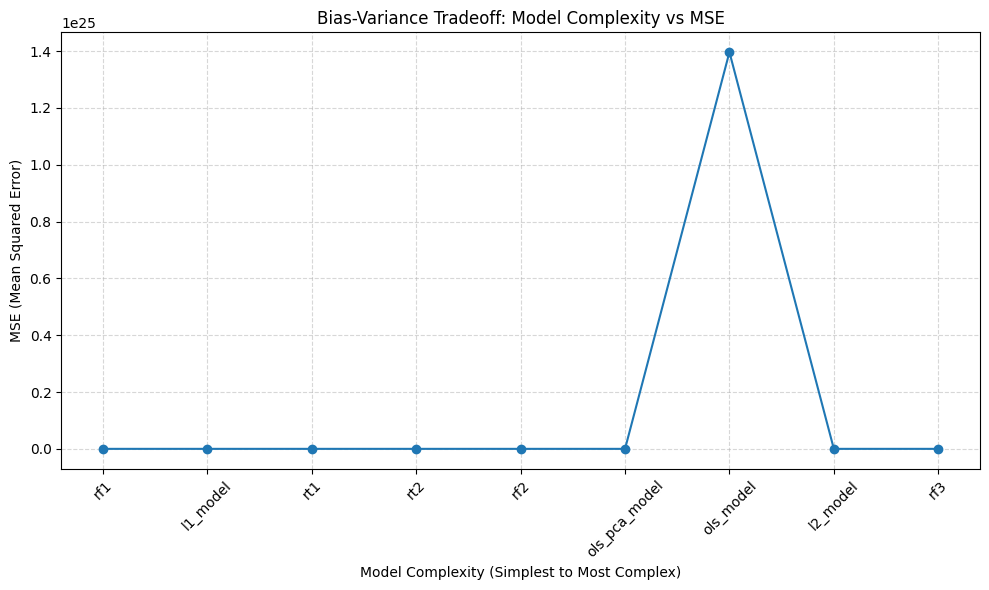

In [12]:
df = df[df['model_complexity'] != 1]
plt.figure(figsize=(10, 6))
plt.plot(df['model_complexity'], df['MSE'], marker='o', linestyle='-')
plt.xticks(df['model_complexity'], df['model_name'], rotation=45)
plt.xlabel('Model Complexity (Simplest to Most Complex)')
plt.ylabel('MSE (Mean Squared Error)')
plt.title('Bias-Variance Tradeoff: Model Complexity vs MSE')
plt.grid(visible=True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

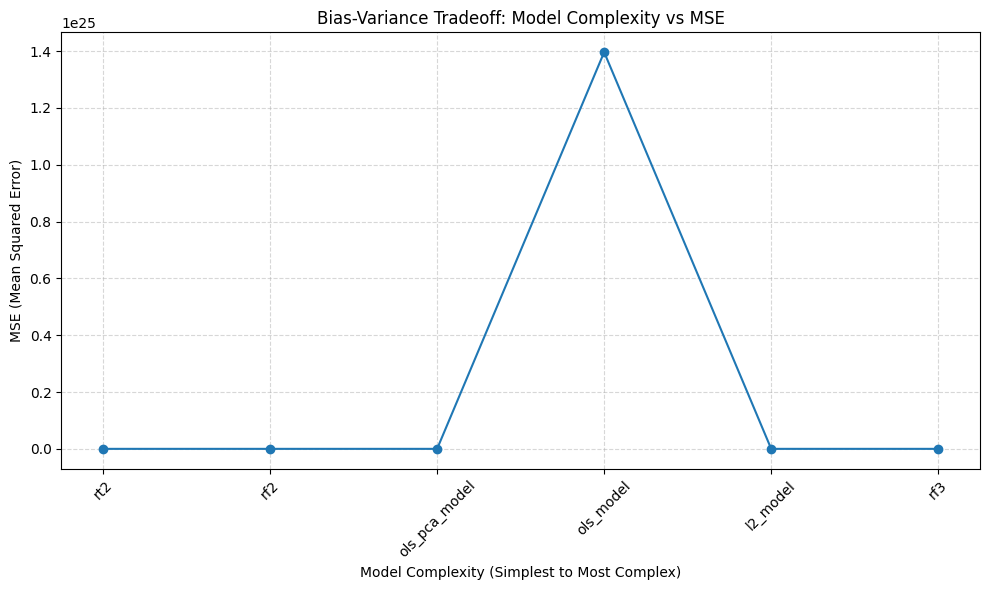

In [13]:
df_filtered = df[df['model_complexity'] > 4]
plt.figure(figsize=(10, 6))
plt.plot(df_filtered['model_complexity'], df_filtered['MSE'], marker='o', linestyle='-')
plt.xticks(df_filtered['model_complexity'], df_filtered['model_name'], rotation=45)
plt.xlabel('Model Complexity (Simplest to Most Complex)')
plt.ylabel('MSE (Mean Squared Error)')
plt.title('Bias-Variance Tradeoff: Model Complexity vs MSE')
plt.grid(visible=True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### Winning model performance on the test dataset

In [14]:
winning_mode = models['rt3']
y_train_pred_tree = winning_mode.predict(X_train_scaled)
y_test_pred_tree = winning_mode.predict(X_test_scaled)
y_val_pred_tree = winning_mode.predict(X_val_scaled)

# Evaluate performance
train_mse_tree, train_rmse_tree, train_r2_tree = evaluate_model(y_train, y_train_pred_tree)
val_mse_tree, val_rmse_tree, val_r2_tree = evaluate_model(y_val, y_val_pred_tree)
test_mse_tree, test_rmse_tree, test_r2_tree = evaluate_model(y_test, y_test_pred_tree)

# Print training metrics
print("Decision Tree Regression Model - Training Metrics:")
print(f"MSE: {train_mse_tree:.4f}, RMSE: {train_rmse_tree:.4f}, R²: {train_r2_tree:.4f}")

# Print validation metrics
print("\nDecision Tree Regression Model - Validation Metrics:") 
print(f"MSE: {val_mse_tree:.4f}, RMSE: {val_rmse_tree:.4f}, R²: {val_r2_tree:.4f}")

# Print testing metrics
print("\nDecision Tree Regression Model - Testing Metrics:") 
print(f"MSE: {test_mse_tree:.4f}, RMSE: {test_rmse_tree:.4f}, R²: {test_r2_tree:.4f}")

Decision Tree Regression Model - Training Metrics:
MSE: 2.6747, RMSE: 1.6354, R²: 0.9997

Decision Tree Regression Model - Validation Metrics:
MSE: 3.0939, RMSE: 1.7589, R²: 0.9996

Decision Tree Regression Model - Testing Metrics:
MSE: 3.1037, RMSE: 1.7617, R²: 0.9997
